In [81]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 4

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [82]:
time = np.arange(0, 100, 0.1)
#label = np.sin(time) + np.square(np.cos(time)) - np.square(np.square(np.cos(time))) #+ np.random.normal(scale=0.1, size=len(time))
label = [np.sin(x) + np.square(np.cos(x)) - np.square(np.square(np.cos(x)))  for x in time]
label = [x if x > 0 else 0.1 for x in label]

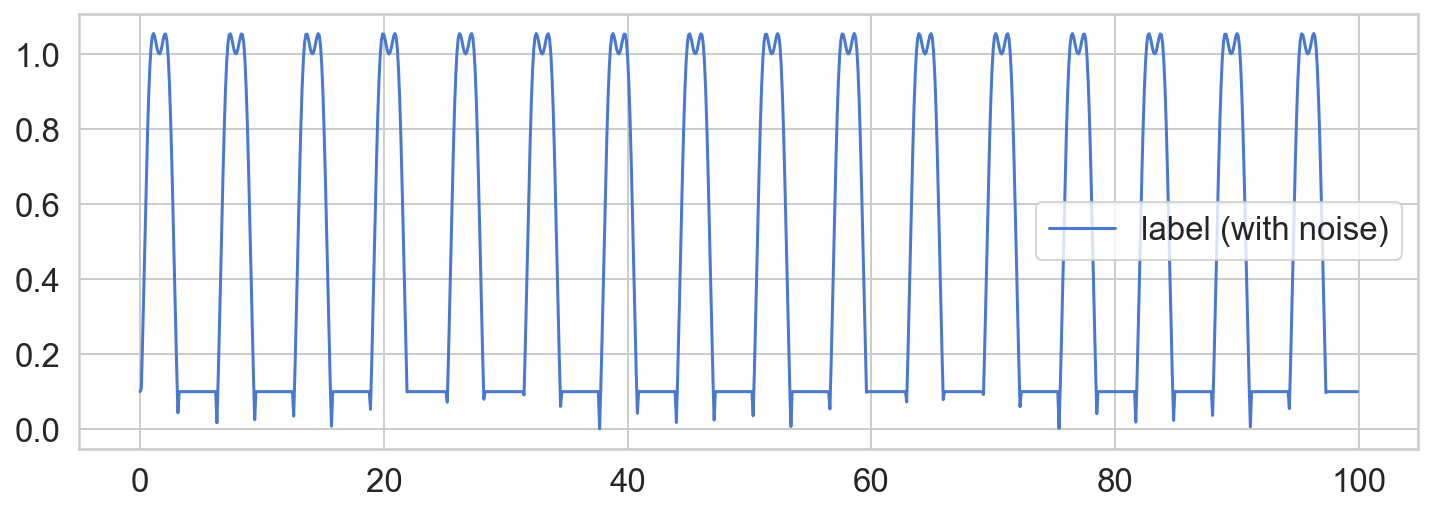

In [83]:
plt.plot(time, label, label='label (with noise)')
plt.legend()

In [86]:
df = pd.DataFrame(dict(label=label), index=time, columns=['label'])
df.head()

,label
0.0,0.100000
0.1,0.109701
0.2,0.236581
0.3,0.375225
0.4,0.518068


In [87]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

800 200


In [88]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [89]:
time_steps = 15

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.label, time_steps)
X_test, y_test = create_dataset(test, test.label, time_steps)

print(X_train.shape, y_train.shape)

(785, 15, 1) (785,)


In [90]:
X_train[0]

array([[0.1       ],
       [0.10970079],
       [0.23658099],
       [0.37522549],
       [0.51806828],
       [0.65644389],
       [0.78181669],
       [0.88699548],
       [0.96714294],
       [1.02042171],
       [1.04817644],
       [1.05462397],
       [1.04610171],
       [1.0299936 ],
       [1.013504  ]])

In [91]:
df.head(11)

,label
0.0,0.100000
0.1,0.109701
0.2,0.236581
0.3,0.375225
0.4,0.518068
0.5,0.656444
0.6,0.781817
0.7,0.886995
0.8,0.967143
0.9,1.020422


In [92]:
y_train[0]

1.0024737007727587

In [93]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.LSTM(64, return_sequences=True))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(0.0001))

In [94]:
callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(
    X_train, y_train, 
    epochs=1000, 
    batch_size=16, 
    validation_split=0.1, 
    verbose=1, 
    shuffle=False,
    callbacks=[callback]
)

Epoch 1/1000
45/45 [==============================] - 2s 48ms/step - loss: 0.2826 - val_loss: 0.1488
Epoch 2/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.1433 - val_loss: 0.1388
Epoch 3/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.1305 - val_loss: 0.1304
Epoch 4/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.1245 - val_loss: 0.1247
Epoch 5/1000
45/45 [==============================] - 1s 14ms/step - loss: 0.1184 - val_loss: 0.1181
Epoch 6/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.1116 - val_loss: 0.1101
Epoch 7/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.1032 - val_loss: 0.0997
Epoch 8/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.0922 - val_loss: 0.0859
Epoch 9/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.0782 - val_loss: 0.0689
Epoch 10/1000
45/45 [==============================] - 1s 15ms/step - loss: 0.0630 - val_lo

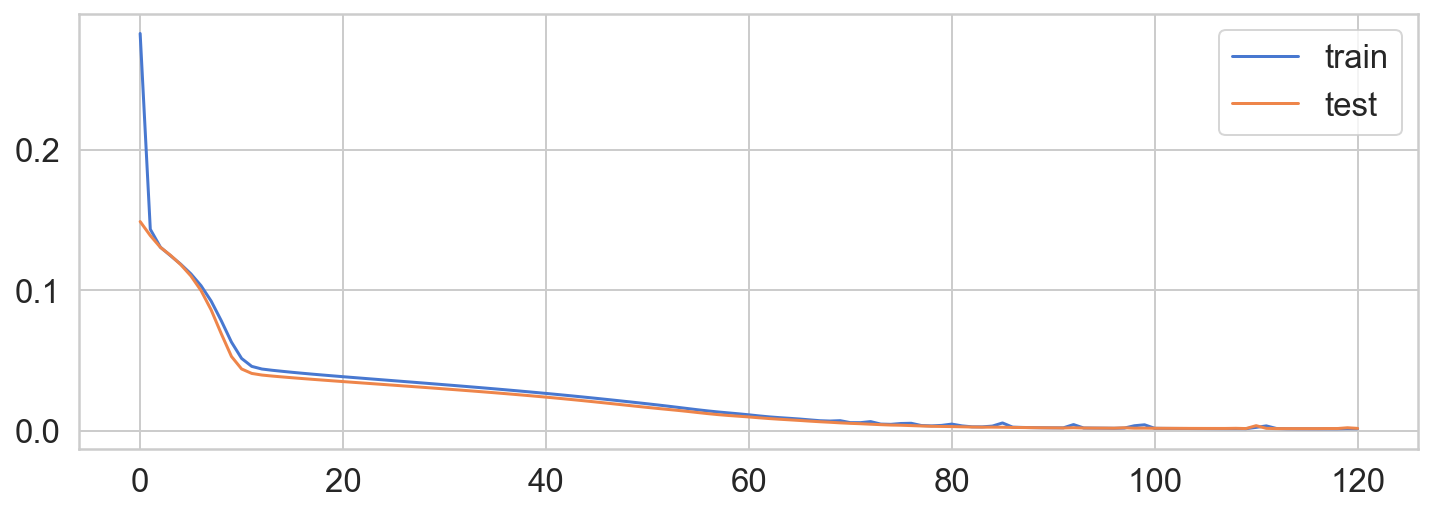

In [95]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [96]:
y_pred = model.predict(X_test)
#smape_loss(pd.Series(y_test), pd.Series(y_pred))

In [97]:
y_pred.shape

(185, 1)

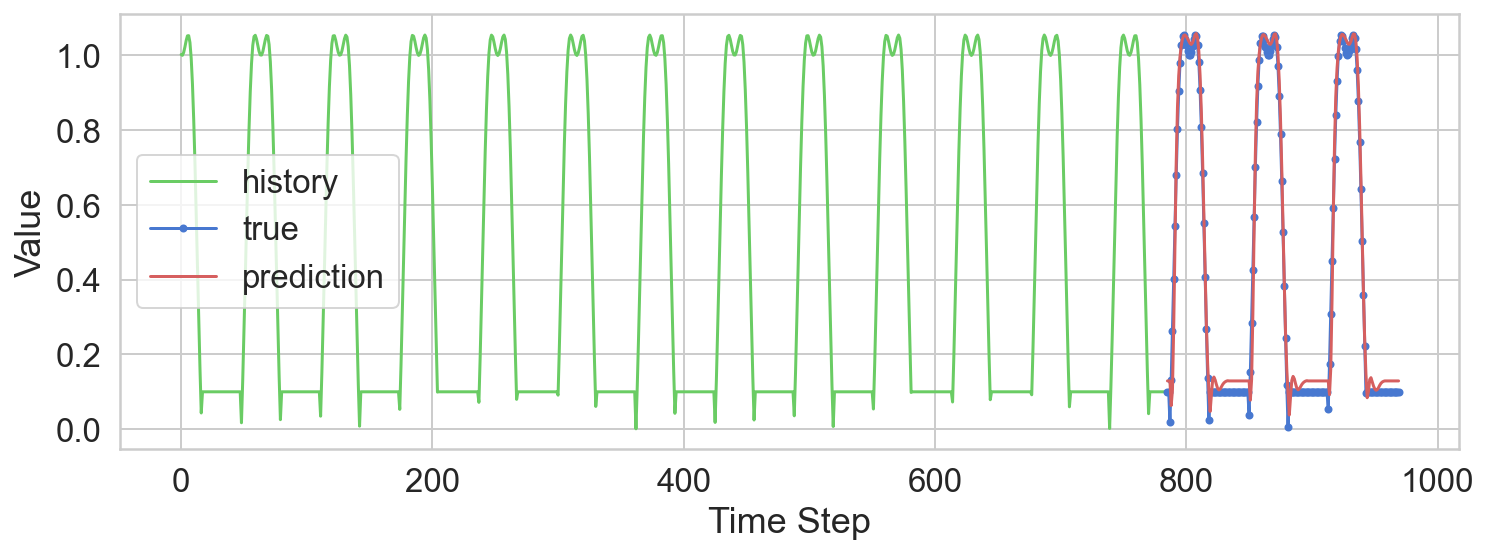

In [98]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

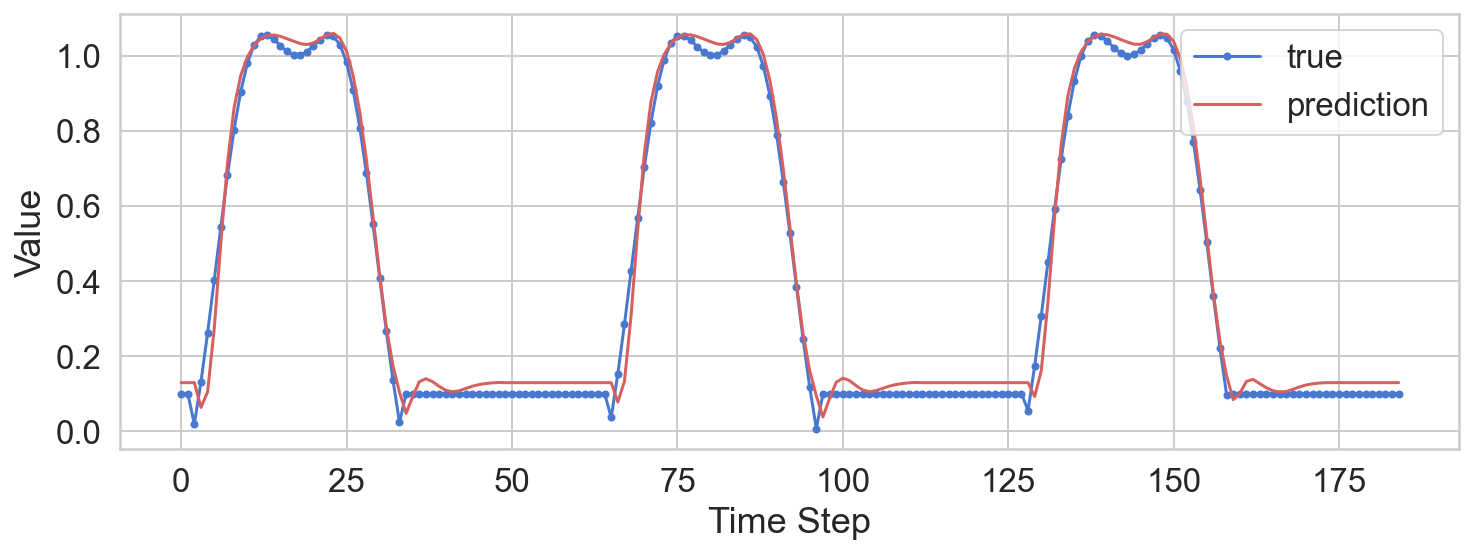

In [99]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Using SkTime

In [100]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys
%matplotlib inline

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

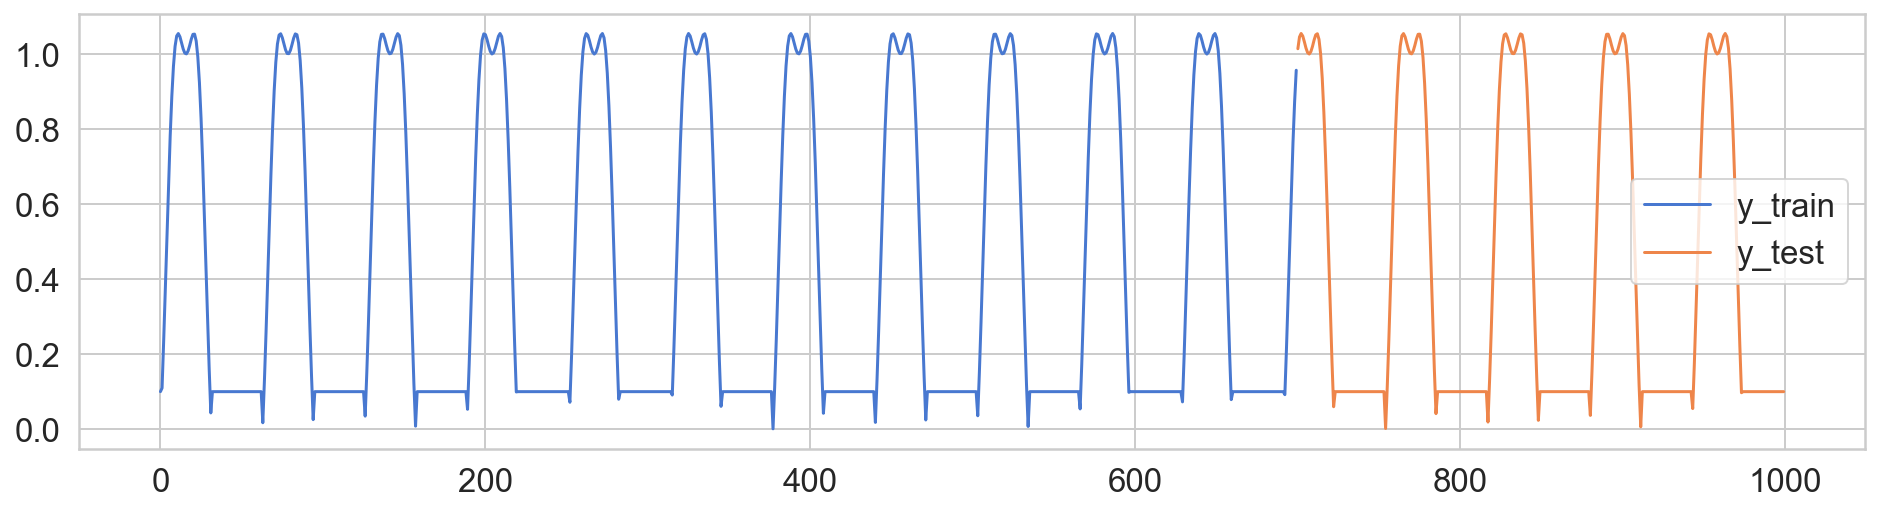

In [101]:
y_train, y_test = temporal_train_test_split(pd.Series(label), test_size=0.3)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])

1.0136917634020008

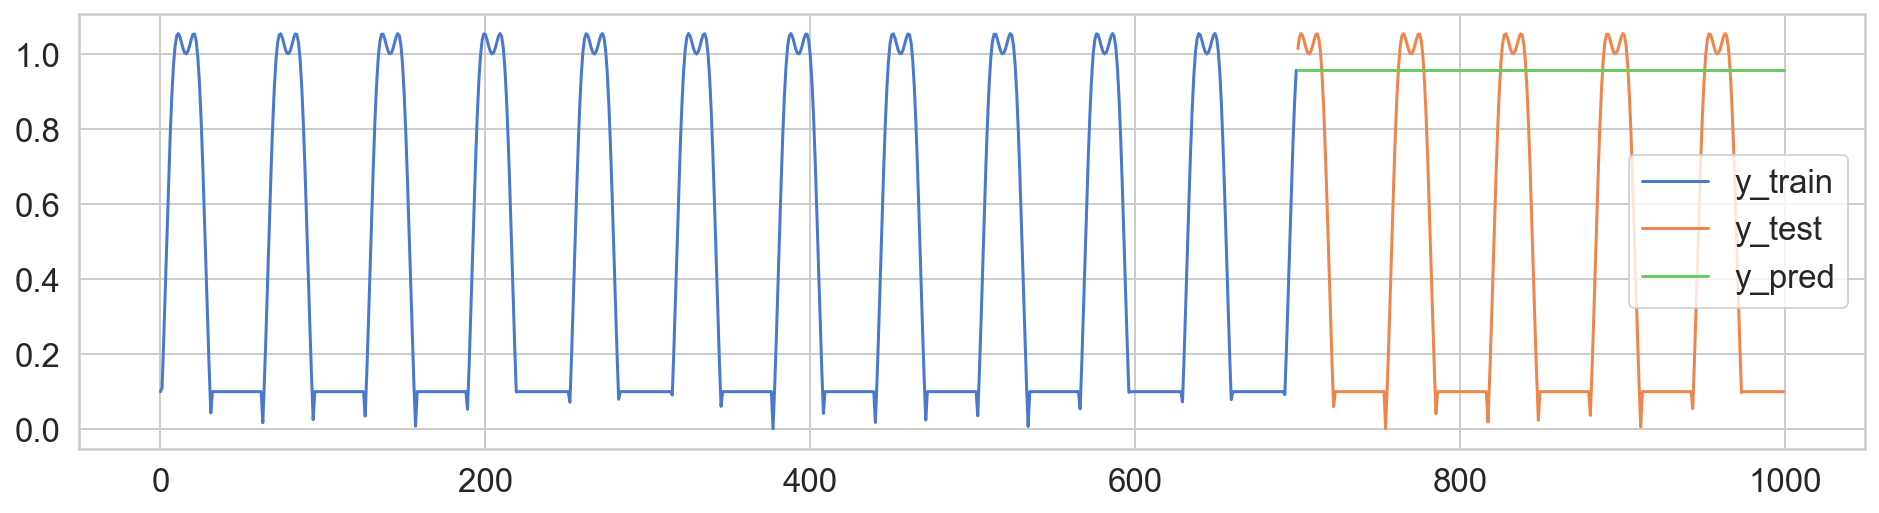

In [102]:
fh = np.arange(1, y_test.shape[0]+1)
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

0.6041752809807817

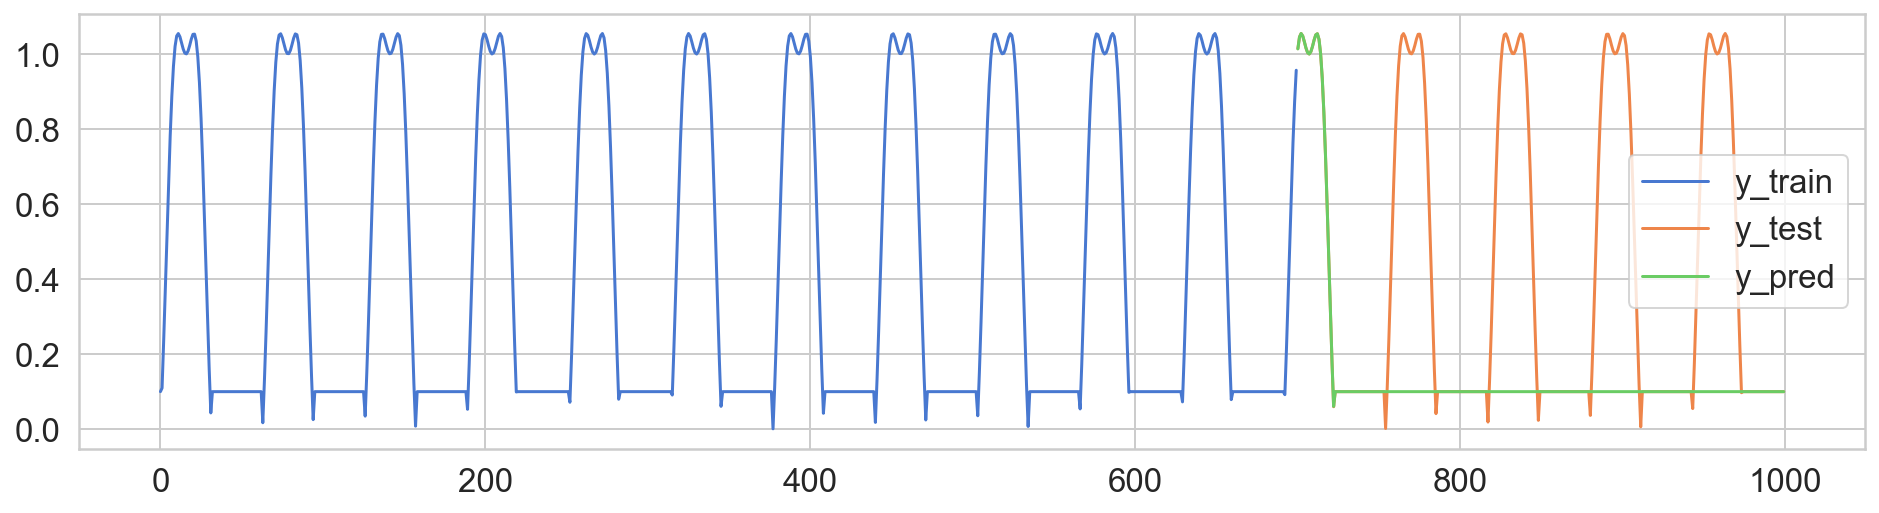

In [103]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.8807753535352731

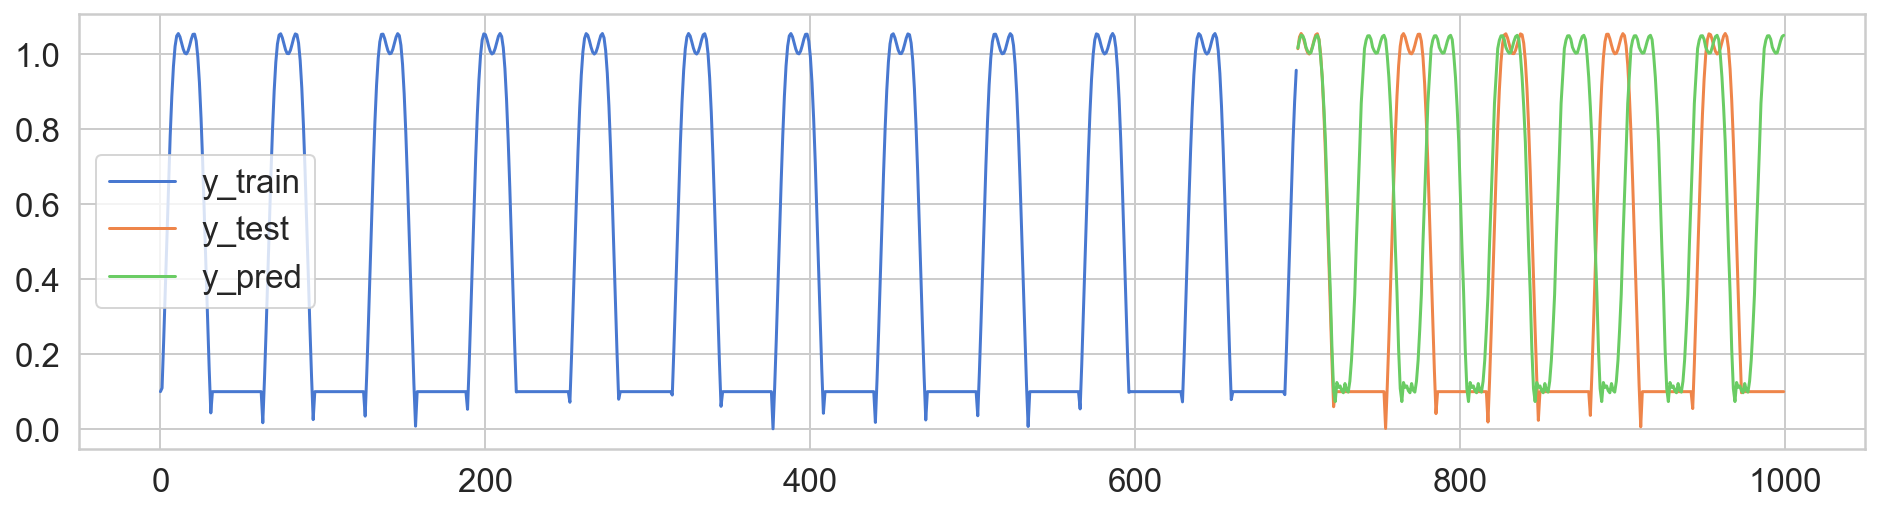

In [107]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\ProgramData\Miniconda3\envs\tensorflow\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  Conve

0.9604253867941914

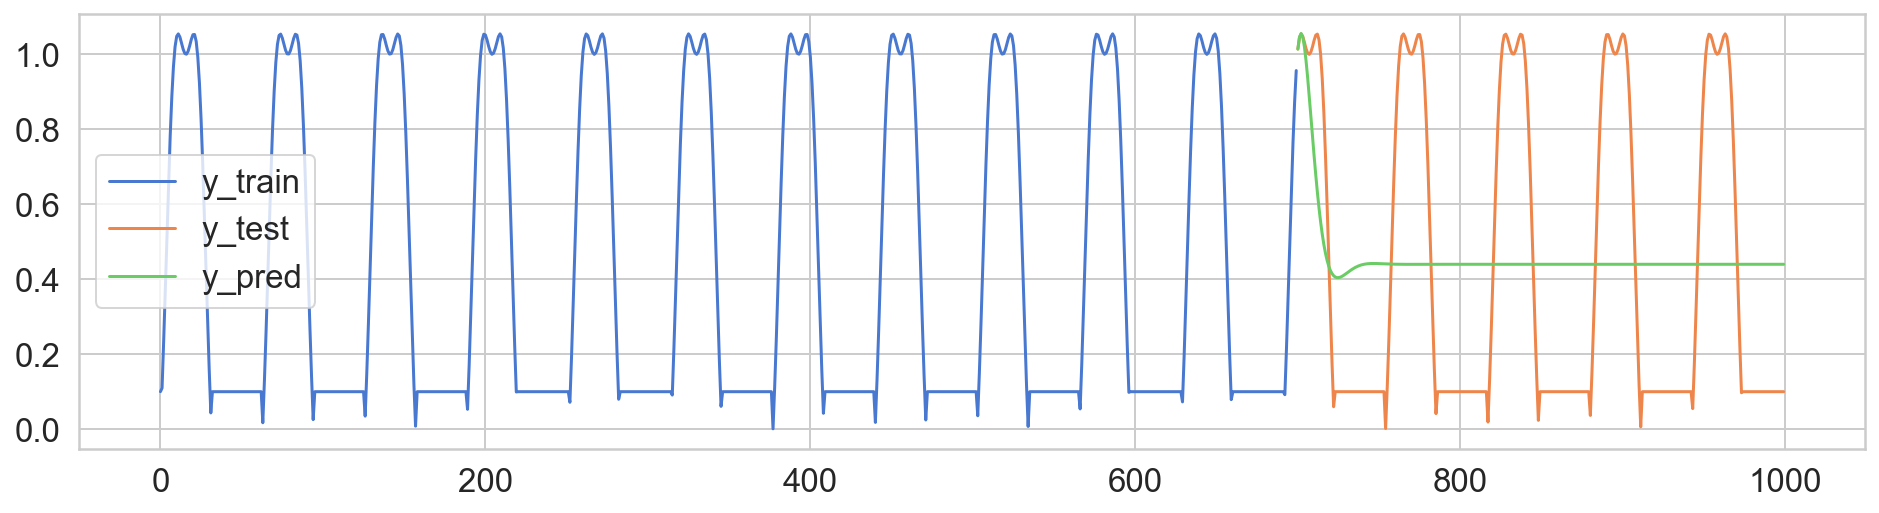

In [108]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA()
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

1.6355440504381427

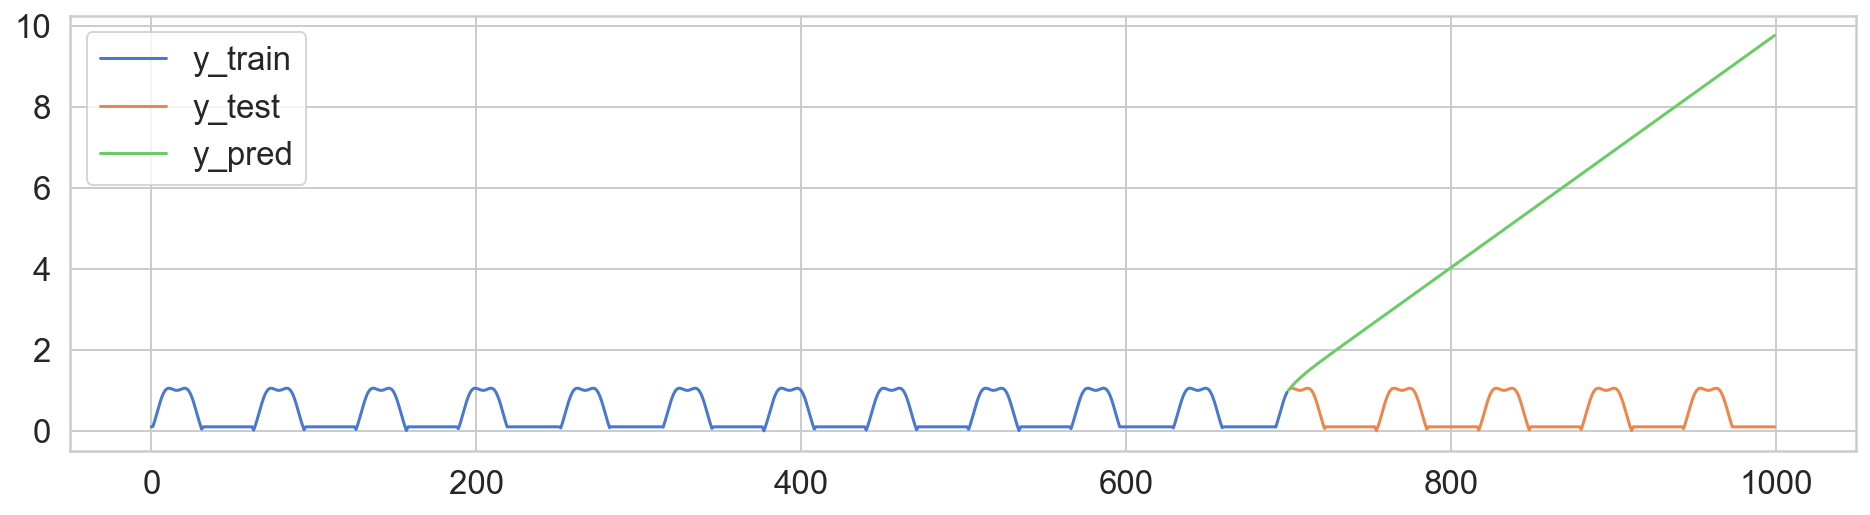

In [112]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="additive", sp=2)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="additive", sp=2)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="additive", sp=2))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

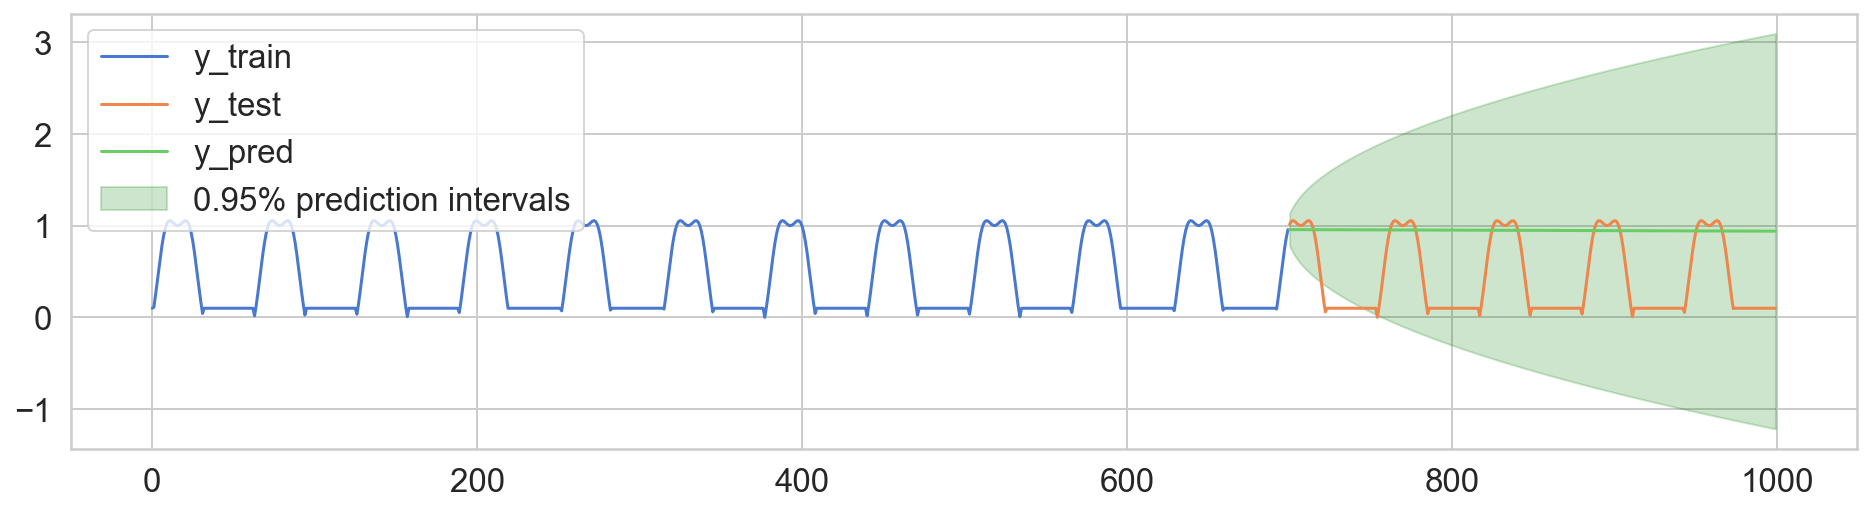

In [113]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=1)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_test, y_pred)

fig, ax = plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
plt.legend();

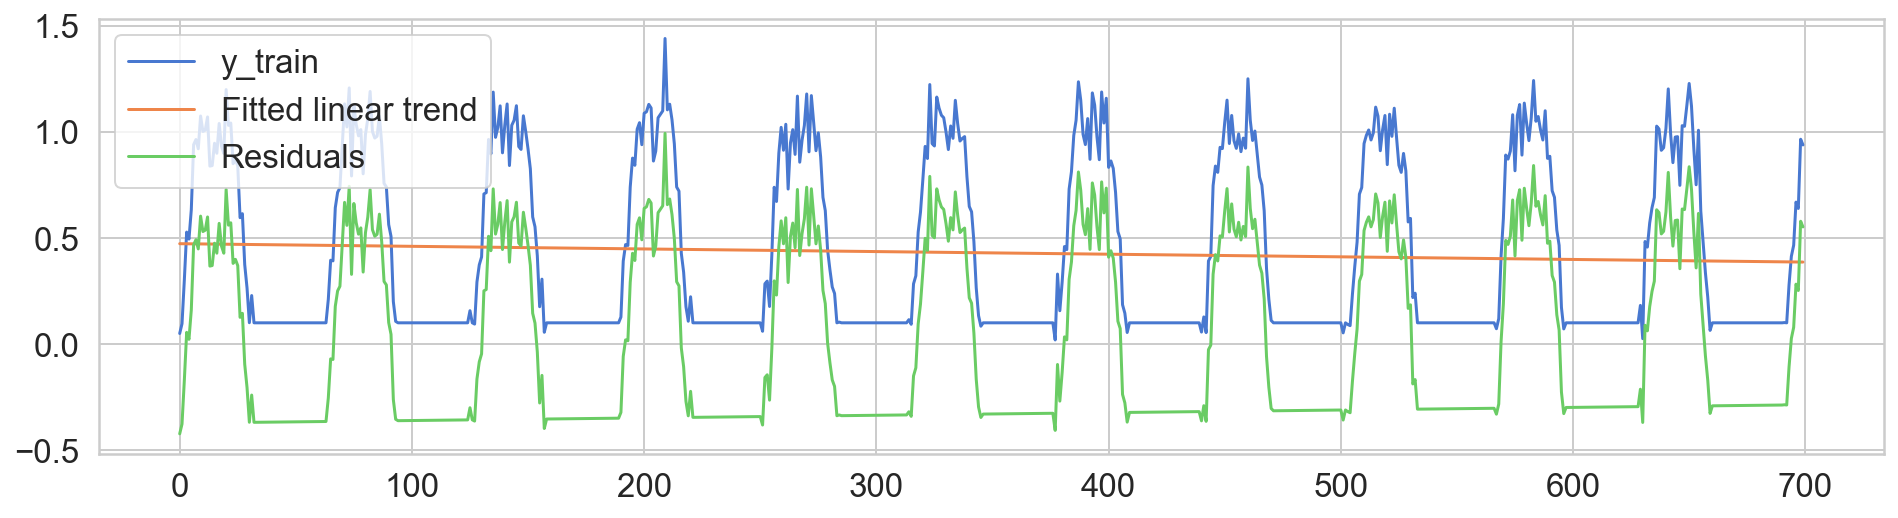

In [77]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.single_series.detrend import Detrender

# liner detrending
forecaster = PolynomialTrendForecaster(degree=1)
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)

# internally, the Detrender uses the in-sample predictions of the PolynomialTrendForecaster
forecaster = PolynomialTrendForecaster(degree=1)
fh_ins = -np.arange(len(y_train)) # in-sample forecasting horizon
y_pred = forecaster.fit(y_train).predict(fh=fh_ins)

plot_ys(y_train, y_pred, yt, labels=["y_train", "Fitted linear trend", "Residuals"]);